In [12]:
import torch

In [17]:
torch.cat(4500*[torch.arange(0,96+24).type(torch.float).unsqueeze(0)]).shape

torch.Size([4500, 120])

In [11]:
for i in range(11):
    print(3077-i*300)

3077
2777
2477
2177
1877
1577
1277
977
677
377
77


In [1]:
import pandas as pd

In [3]:
df1 = pd.DataFrame(
    {
        "col1": [1, 2, 3]
    }
)
df2 = pd.DataFrame(
    {
        "col2": [1, 2, 3, 4]
    }
)
pd.concat([df1, df2], axis=1)

,col1,col2
0,1.0,1
1,2.0,2
2,3.0,3
3,NaN,4


In [166]:
import pandas as pd
data = pd.read_csv(f"../preprocessedDataset/pre1.csv")

In [167]:
data.shape

(800000, 53)

In [ ]:
batch_size = 99999
for i in range(10):
    df = pd.read_csv(f"../preprocessedDataset/pre1.csv")

In [178]:
from collections import defaultdict
n_null = defaultdict(int)
n_sample = 0

In [181]:
for chunk in tqdm.tqdm(pd.read_csv(f"../preprocessedDataset/pre1.csv", chunksize=99999)):
    n_sample += chunk[chunk.columns[0]].size
    for col in chunk.columns:
        n_null[col] += chunk[col].isnull().sum()

9it [00:02,  3.56it/s]


In [187]:
n = 0
for chunk in tqdm.tqdm(pd.read_csv(f"../preprocessedDataset/pre1.csv", chunksize=99999)):
    chunk.to_csv("../preprocessedDataset/pre1-1.csv", mode="a", index=False, header=True if n == 0 else False)
    n += 1

9it [00:19,  2.14s/it]


In [263]:
import pyarrow

import pandas as pd 
import pyarrow.parquet as pq
import pyarrow as pa

# dataframe = pd.read_csv('content.csv')
# output = "/Users/myTable.parquet"

# # Create a parquet table from your dataframe
# table = pa.Table.from_pandas(dataframe)

# # Write direct to your parquet file
# pq.write_to_dataset(table , root_path=output)

csv_filePath = f"../originalDataset/train.csv"
pqt_filePath = "../preprocessedDataset/pre1-2.parquet"
batch_size = 99999

def csv2Parquet(csv_filePath, pqt_filePath, batch_size):
    '''
    读csv的时候，每次读入最多batch_size行，然后写入parquet中。
    可以记录进度情况，不会两眼一抹黑。
    '''    
    n = 0
    writer = None
    schema = None
    for chunk in tqdm.tqdm(pd.read_csv(csv_filePath, chunksize=batch_size)):
        if n == 0:
            table = pa.Table.from_pandas(chunk)
            writer = pq.ParquetWriter(pqt_filePath, table.schema)
            schema = table.schema
        else:
            # for colName in table.schema.names:
            table = pa.Table.from_pandas(chunk, schema=schema)

        writer.write_table(table=table)
        n += 1
    if writer:
        writer.close()  

In [264]:
csv2Parquet(
    "../originalDataset/train.csv", 
    "../preprocessedDataset/pre1-2.parquet", 
    100000
)

8it [00:03,  2.57it/s]


In [266]:
pd.read_parquet(pqt_filePath).tail()

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
799995,799995,25000.0,3,14.49,860.41,C,C4,2659.0,7 years,1,...,6.0,2.0,12.0,13.0,10.0,14.0,0.0,0.0,0.0,3.0
799996,799996,17000.0,3,7.90,531.94,A,A4,29205.0,10+ years,0,...,15.0,16.0,2.0,19.0,2.0,7.0,0.0,0.0,0.0,0.0
799997,799997,6000.0,3,13.33,203.12,C,C3,2582.0,10+ years,1,...,4.0,26.0,4.0,10.0,4.0,5.0,0.0,0.0,1.0,4.0
799998,799998,19200.0,3,6.92,592.14,A,A4,151.0,10+ years,0,...,10.0,6.0,12.0,22.0,8.0,16.0,0.0,0.0,0.0,5.0
799999,799999,9000.0,3,11.06,294.91,B,B3,13.0,5 years,0,...,3.0,4.0,4.0,8.0,3.0,7.0,0.0,0.0,0.0,2.0


In [269]:
pq.read_table(pqt_filePath, columns=["loanAmnt"]).to_pandas()

,loanAmnt
0,35000.0
1,18000.0
2,12000.0
3,11000.0
4,3000.0
...,...
799995,25000.0
799996,17000.0
799997,6000.0
799998,19200.0


In [268]:
pd.read_parquet(pqt_filePath, usecols=["loanAmnt"])

TypeError: read_table() got an unexpected keyword argument 'usecols'

In [262]:
n = 0
writer = None
schema = None
for chunk in tqdm.tqdm(pd.read_csv(csv_filePath, chunksize=batch_size)):
    if n == 0:
        table = pa.Table.from_pandas(chunk)
        writer = pq.ParquetWriter(pqt_filePath, table.schema)
        schema = table.schema
    else:
        # for colName in table.schema.names:
        table = pa.Table.from_pandas(chunk, schema=schema)
    
    writer.write_table(table=table)
    n += 1
if writer:
    writer.close()    


9it [00:03,  2.73it/s]


In [260]:
colName = "id"
schema[schema.get_field_index(colName)]

pyarrow.Field<id: int64>

In [240]:
def get_table(table_schema: pa.Schema, chunk: pd.DataFrame) -> pa.Table:
    for column_name in table_schema.names:
        if column_name in PARQUET_DTYPES.keys():
            table_schema = table_schema.set(table_schema.get_field_index(column_name), PARQUET_DTYPES.get(column_name))
    table = pa.Table.from_pandas(chunk, schema=table_schema)
    return table
for index, chunk in enumerate(pd.read_csv(csv_file, chunksize=batch_size)):
    if index == 0:
        table_schema = pa.Schema.from_pandas(chunk)
        table = get_table(table_schema, chunk)
        table_schema = table.schema
        pqwriter = pq.ParquetWriter(updated_path, table_schema)
    else:
        table = pa.Table.from_pandas(chunk, schema=table_schema)
    pqwriter.write_table(table)

NameError: name 'PARQUET_DTYPES' is not defined

In [205]:
pd.read_parquet(pqt_filePath).shape

ArrowInvalid: Could not open Parquet input source '<Buffer>': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.

In [200]:
pd.read_csv(csv_filePath, header=None)

/Users/minkexiu/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52) have mixed types.Specify dtype option on import or set low_memory=False.


,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n11,n12,n13,n14,issueYear,issueMonth,earliesCreditLineYear,earliesCreditLineMonth,issueDateDT,earliesCreditLineDT
1,0,35000.0,5,19.52,917.97,4,21,320.0,2.0,2,...,0.0,0.0,0.0,2.0,2014,7,2001,8,2587,-2130
2,1,18000.0,5,18.49,461.9,3,16,219843.0,5.0,0,...,0.0,0.0,0.0,2.0,2012,8,2002,5,1888,-1857
3,2,12000.0,5,16.99,298.17,3,17,31698.0,8.0,0,...,0.0,0.0,0.0,4.0,2015,10,2006,5,3044,-396
4,3,11000.0,3,7.26,340.96,0,3,46854.0,10.0,1,...,0.0,0.0,0.0,1.0,2015,8,1999,5,2983,-2953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799996,799995,25000.0,3,14.49,860.41,2,13,2659.0,7.0,1,...,0.0,0.0,0.0,3.0,2016,7,2011,8,3318,1522
799997,799996,17000.0,3,7.9,531.94,0,3,29205.0,10.0,0,...,0.0,0.0,0.0,0.0,2013,4,1989,5,2131,-6605
799998,799997,6000.0,3,13.33,203.12,2,12,2582.0,10.0,1,...,0.0,0.0,1.0,4.0,2015,10,2002,7,3044,-1796
799999,799998,19200.0,3,6.92,592.14,0,3,151.0,10.0,0,...,0.0,0.0,0.0,5.0,2015,2,1994,1,2802,-4899


In [189]:
df = pd.read_csv("../preprocessedDataset/pre1-1.csv").shape

In [ ]:
df.to_csv("../preprocessedDataset/pre1-2.csv", chunk)

这里主要是测试一些代码而已，不以获得能跑的代码为主要目的。

In [165]:
import time
for i in tqdm.tqdm(range(10)):
    time.sleep(1)

100%|███████████████████████████████████████████| 10/10 [00:10<00:00,  1.01s/it]


In [2]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
import pandas as pd
import numpy as np
import tqdm, datetime, pickle
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

import ngboost as ngb

from sklearn import datasets

import plotnine
from plotnine import *

import seaborn as sns

# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, Flatten

In [3]:
torch.nn.Conv2d?

In [4]:
torch.nn.ReLU?

In [23]:
a = np.array(
    [1, 2]
)
b = np.array(
    [
        [1, 2],
        [3, 4]
    ]
)
(a @ b).pow(2)

AttributeError: 'numpy.ndarray' object has no attribute 'pow'

In [24]:
np.dot(b, a).mean().item()

8.0

In [25]:
torch.Tensor(a).pow(2)

tensor([1., 4.])

In [153]:
mean, var = 0., 0.
for i in range(2):
    x = torch.randn(512)
    a = torch.randn(512, 512)
    y = a @ x
    mean += y.mean().item()
    print(y.mean(), y.mean().item())
    var += y.pow(2).mean().item()
mean, var

tensor(-0.1078) -0.10781732946634293
tensor(1.0952) 1.0951733589172363


(0.9873560294508934, 1123.1004028320312)

In [155]:
import math
math.sqrt(512) / math.sqrt(2)

16.0

In [158]:
torch.nn.AvgPool2d?

In [163]:
torch.nn.MaxPool2d?

In [160]:
torch.nn.Conv2d?

In [161]:
torch.flatten?

In [162]:
16*128

2048

# ResNet

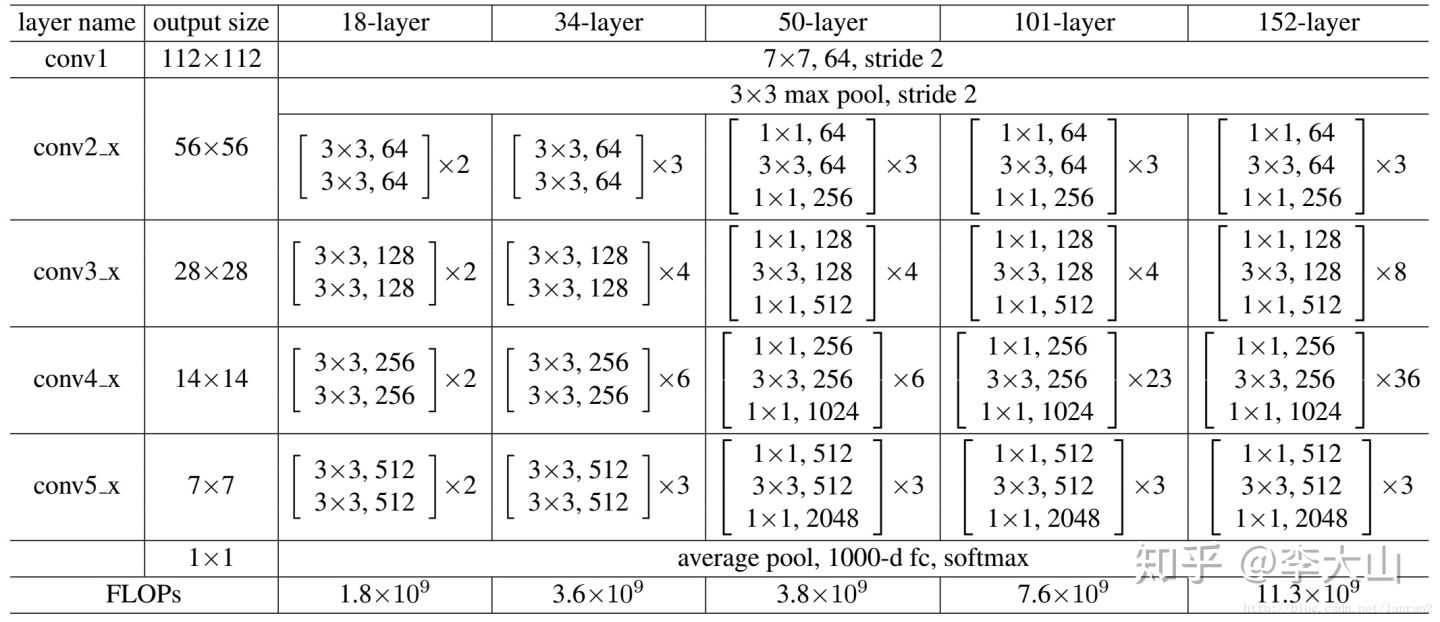

In [ ]:
import torch.nn as nn
import torch


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    """
    注意：原论文中，在虚线残差结构的主分支上，第一个1x1卷积层的步距是2，第二个3x3卷积层步距是1。
    但在pytorch官方实现过程中是第一个1x1卷积层的步距是1，第二个3x3卷积层步距是2，
    这么做的好处是能够在top1上提升大概0.5%的准确率。
    可参考Resnet v1.5 https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch
    """
    expansion = 4

    def __init__(self, in_channel, out_channel, stride=1, downsample=None,
                 groups=1, width_per_group=64):
        '''
        in_channel: 256
        out_channel: 128
        stride: 1
        downsample: 64 --> 256
        groups: 1
        width_per_group: 64 
        '''
        super(Bottleneck, self).__init__()

        width = int(out_channel * (width_per_group / 64.)) * groups ## 128

        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=width,
                               kernel_size=1, stride=1, bias=False)  # squeeze channels
        self.bn1 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv2 = nn.Conv2d(in_channels=width, out_channels=width, groups=groups,
                               kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv3 = nn.Conv2d(in_channels=width, out_channels=out_channel*self.expansion,
                               kernel_size=1, stride=1, bias=False)  # unsqueeze channels
        ## BottleNeck第三个conv层，会比前面两层更宽。
        self.bn3 = nn.BatchNorm2d(out_channel*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x ## 256，来自上一层
        if self.downsample is not None:
            identity = self.downsample(x) ## 64 --> 256

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out) ## 到这里，128也变成512了。

        out += identity ## 于是形状都统一为256，就可以相加了。
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 blocks_num,
                 num_classes=1000,
                 include_top=True,
                 groups=1,
                 width_per_group=64):
        super(ResNet, self).__init__()
        self.include_top = include_top
        self.in_channel = 64

        self.groups = groups
        self.width_per_group = width_per_group

        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, blocks_num[0])
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)
        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # output size = (1, 1)
            self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion: ## 64 != 64*4
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion)
            ) ## 莫名变成256了，这是为嘛？

        layers = []
        layers.append(block(self.in_channel, ## 64
                            channel, ## 64
                            downsample=downsample, ## not None
                            stride=stride, ## 1
                            groups=self.groups, ## 1
                            width_per_group=self.width_per_group)## 64
                     )
        self.in_channel = channel * block.expansion ## 变256

        for _ in range(1, block_num):
            layers.append(block(self.in_channel, ## 256
                                channel, ## 128
                                groups=self.groups, # 1
                                width_per_group=self.width_per_group)) ## 64

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.include_top:
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)

        return x


def resnet34(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet34-333f7ec4.pth
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet50(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet50-19c8e357.pth
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet101(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet101-5d3b4d8f.pth
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes, include_top=include_top)


def resnext50_32x4d(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth
    groups = 32
    width_per_group = 4
    return ResNet(Bottleneck, [3, 4, 6, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)


def resnext101_32x8d(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth
    groups = 32
    width_per_group = 8
    return ResNet(Bottleneck, [3, 4, 23, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)


# GoogleNet

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F


class GoogLeNet(nn.Module):
    def __init__(self, num_classes=1000, aux_logits=True, init_weights=False):
        super(GoogLeNet, self).__init__()
        self.aux_logits = aux_logits

        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        # N x 3 x 224 x 224
        x = self.conv1(x)
        # N x 64 x 112 x 112
        x = self.maxpool1(x)
        # N x 64 x 56 x 56
        x = self.conv2(x)
        # N x 64 x 56 x 56
        x = self.conv3(x)
        # N x 192 x 56 x 56
        x = self.maxpool2(x)

        # N x 192 x 28 x 28
        x = self.inception3a(x)
        # N x 256 x 28 x 28
        x = self.inception3b(x)
        # N x 480 x 28 x 28
        x = self.maxpool3(x)
        # N x 480 x 14 x 14
        x = self.inception4a(x)
        # N x 512 x 14 x 14
        if self.training and self.aux_logits:    # eval model lose this layer
            aux1 = self.aux1(x)

        x = self.inception4b(x)
        # N x 512 x 14 x 14
        x = self.inception4c(x)
        # N x 512 x 14 x 14
        x = self.inception4d(x)
        # N x 528 x 14 x 14
        if self.training and self.aux_logits:    # eval model lose this layer
            aux2 = self.aux2(x)

        x = self.inception4e(x)
        # N x 832 x 14 x 14
        x = self.maxpool4(x)
        # N x 832 x 7 x 7
        x = self.inception5a(x)
        # N x 832 x 7 x 7
        x = self.inception5b(x)
        # N x 1024 x 7 x 7

        x = self.avgpool(x)
        # N x 1024 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 1024
        x = self.dropout(x)
        x = self.fc(x)
        # N x 1000 (num_classes)
        if self.training and self.aux_logits:   # eval model lose this layer
            return x, aux2, aux1
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()

        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)   # 保证输出大小等于输入大小
        )

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)   # 保证输出大小等于输入大小
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)


class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.averagePool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = BasicConv2d(in_channels, 128, kernel_size=1)  # output[batch, 128, 4, 4]

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # aux1: N x 512 x 14 x 14, aux2: N x 528 x 14 x 14
        x = self.averagePool(x)
        # aux1: N x 512 x 4 x 4, aux2: N x 528 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = torch.flatten(x, 1)
        x = F.dropout(x, 0.5, training=self.training)
        # N x 2048
        x = F.relu(self.fc1(x), inplace=True)
        x = F.dropout(x, 0.5, training=self.training)
        # N x 1024
        x = self.fc2(x)
        # N x num_classes
        return x


class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x
